# DTSA-5511 Final Project
Author: Alan Klein

Create Date: 2025-07-21

github link: https://github.com/Saganoky/DTSA-5511-Deep-Learning-Final-Project

## Project Topic
Twitter now called X is a treasure trove a valuable information.  Being able to use Tweets to predict an attribute of the person writing the Tweet can be incredibly useful.  For example, this information can be used for targeted marketing.  This project will tackle a Kaggle competition where the goal is to use Tweets to predict someones political affiliation.  For more information on the contest click the link [here](https://www.kaggle.com/competitions/congressionaltweetcompetitionspring2022/). [1]  My approach will be to use an LSTM, GRU, and a Bi-Directional LSTM and evaluate their performance.


## Setup
The code below imports all the required packages.  This repo uses UV for package management, see https://docs.astral.sh/uv/ for more information.  If you are not familiar with UV I highly recommend you check it out. It fast and easy to use. Additionally, it is being used more and more in industry.

In [92]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# We'll be using Pytorch's text library called torchtext! 
from tqdm.notebook import trange, tqdm

import numpy as np
import matplotlib.pyplot as plt 

import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /home/aklein01/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aklein01/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/aklein01/nltk_data...


True

## Data

One of the best places to find information about a dataset is by reading about the data from the source.  Per the Kaggle competition[1] page.

- The dataset is a collection of tweets posted by Congressional politicians on Twitter [excluding tweets with no hashtags.]

- Files
    - congressional_tweet_training_data.csv - the training set consisting of 592,803 records
    - congressional_tweet_test_data.csv - the test set consisting of 265,000 records
    - sample_submission.csv - a sample submission file in the correct format

- Column Descriptions
    - Id : id number associated with the tweet
    - favorite _ count : number of times the tweet was favorited
    - full_text : full text of the tweet
    - hashtags : list of hashtags included in the tweet
    - retweet_count : number of times the tweet has been retweeted
    - year : year of the tweet
    - party : partisanship of the owner of the tweet [D = 'Democrat', R = 'Republican'].  This column is called party_id in the training data and party in the test data.  It is always set to D in the test data.


In [2]:
# This sets up the Kaggle API.  You need to have a Kaggle account and a token to be able to run this code.  
# This video gives a pretty good explanation of how to get the token: https://www.youtube.com/watch?v=gkEbaMgvLs8&t=188s
api = KaggleApi()
api.authenticate()

In [3]:
# Run these two commands to download and unzip the data sets into the data folder.
!kaggle competitions download -c congressionaltweetcompetitionspring2022
!unzip congressionaltweetcompetitionspring2022.zip -d data/

  0%|                                               | 0.00/76.0M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 76.0M/76.0M [00:00<00:00, 1.29GB/s]
Archive:  congressionaltweetcompetitionspring2022.zip
  inflating: data/congressional_tweet_test_data.csv  
  inflating: data/congressional_tweet_training_data.csv  
  inflating: data/sample_submission.csv  


In [13]:
test = pd.read_csv('data/congressional_tweet_test_data.csv')
train = pd.read_csv('data/congressional_tweet_training_data.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [28]:
# Basic information about the datasets
print("Test Data:")
print("Shape:", test.shape)
print("Head:")
print(test.head())
print("Info:")
print(test.info())
print("Describe:")
print(test.describe())

print("\nTrain Data:")
print("Shape:", train.shape)
print("Head:")
print(train.head())
print("Info:")
print(train.info())
print("Describe:")
print(train.describe())

print("\nSample Submission Data:")
print("Shape:", sample_submission.shape)
print("Head:")
print(sample_submission.head())

Test Data:
Shape: (265000, 7)
Head:
   Id  favorite_count                                          full_text  \
0   0              70  b'#TaxReform improved the playing field for Am...   
1   1              27  b'This #NativeWomensEqualPay Day, we recommit ...   
2   2              49  b"\xe2\x80\x9cI became convinced that our gene...   
3   3              14  b'During #NationalAdoptionMonth, we honor the ...   
4   4              13  b'Happy #AirborneDay to our @USArmy paratroope...   

                        hashtags  retweet_count    year party  
0                      TaxReform             13  2018.0     D  
1           NativeWomensEqualPay             11     NaN     D  
2     MeToo ShatteringTheSilence             24  2017.0     D  
3          NationalAdoptionMonth              2  2019.0     D  
4  AirborneDay AirborneAllTheWay              7  2018.0     D  
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265000 entries, 0 to 264999
Data columns (total 7 columns):
 #   Co

## Exploratory Data Analysis
- The training and test datasets exhibit similar distributions across most features. The primary exception is the retweet count, which shows a notable difference due to the presence of an extreme outlier in the test set.

- The class distribution in the training set is relatively balanced, so no rebalancing techniques will be applied.

- There are missing values in the year column, with approximately 20,000 missing entries in the training data and around 10,000 in the test data.

- The hashtags column often contains multiple hashtags per entry. The top 20 hashtags are consistent between the training and test sets.

- The word count distributions in the full_text column are also similar between the two datasets.

- The full_text field requires cleaning, as it contains artifacts such as leading byte strings (e.g., b'...'), hashtags, and user mentions (e.g., @username).

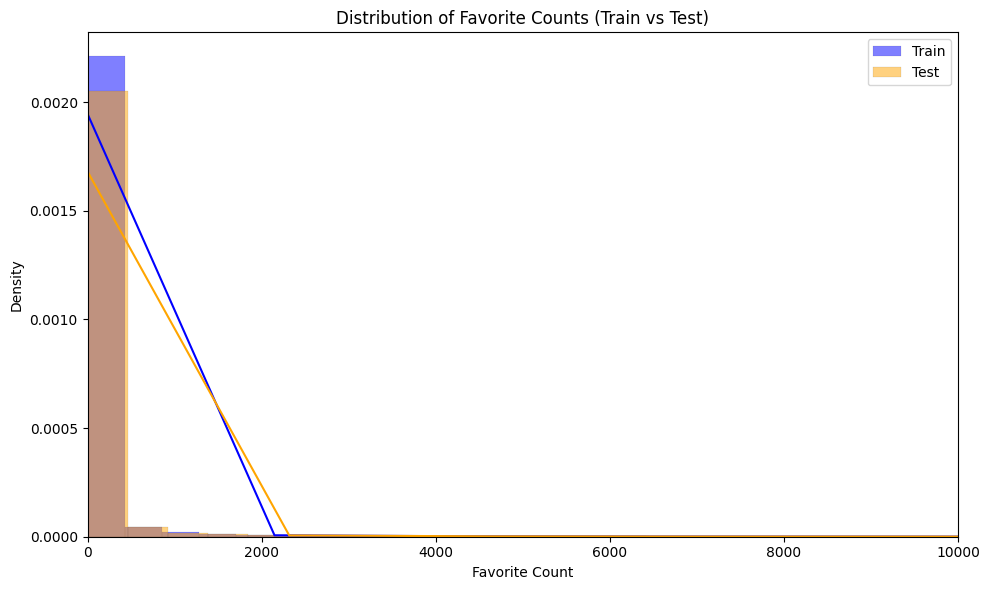

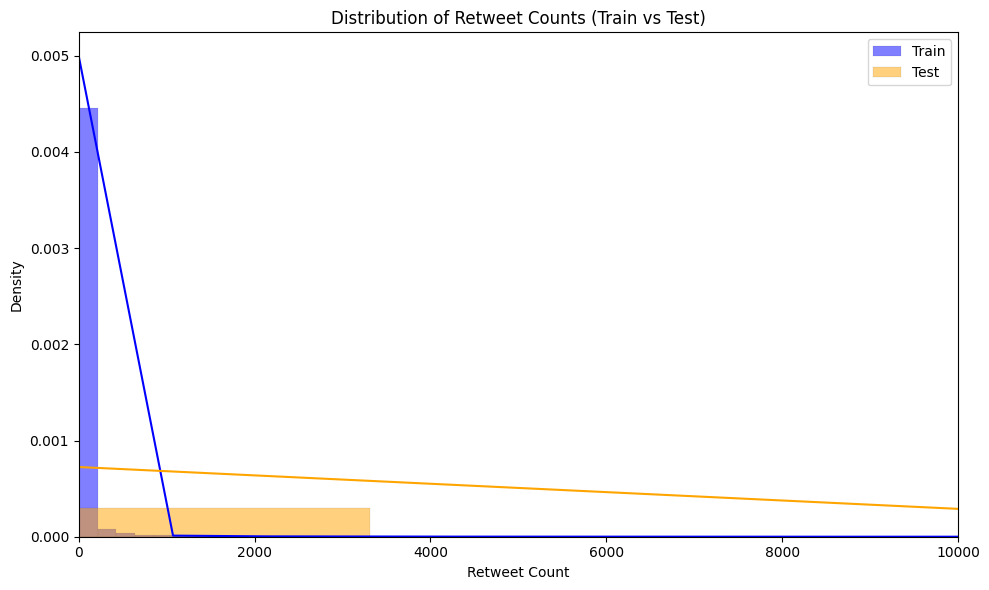

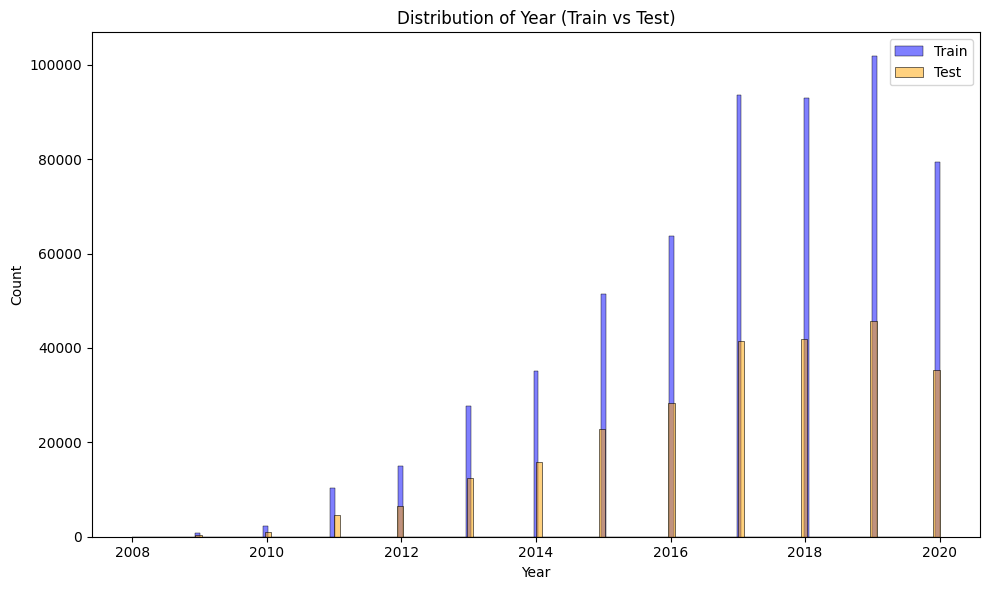

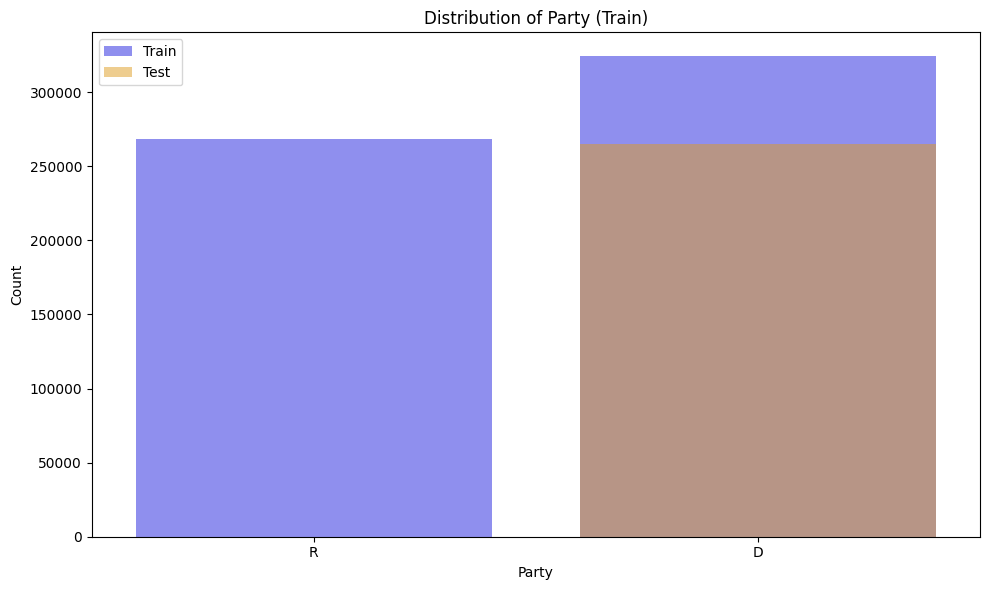

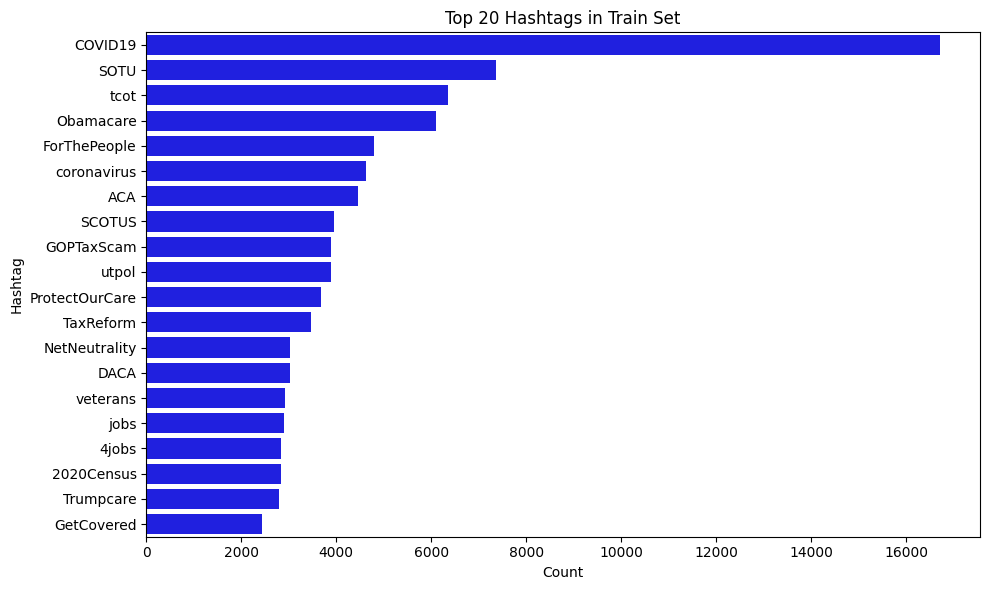

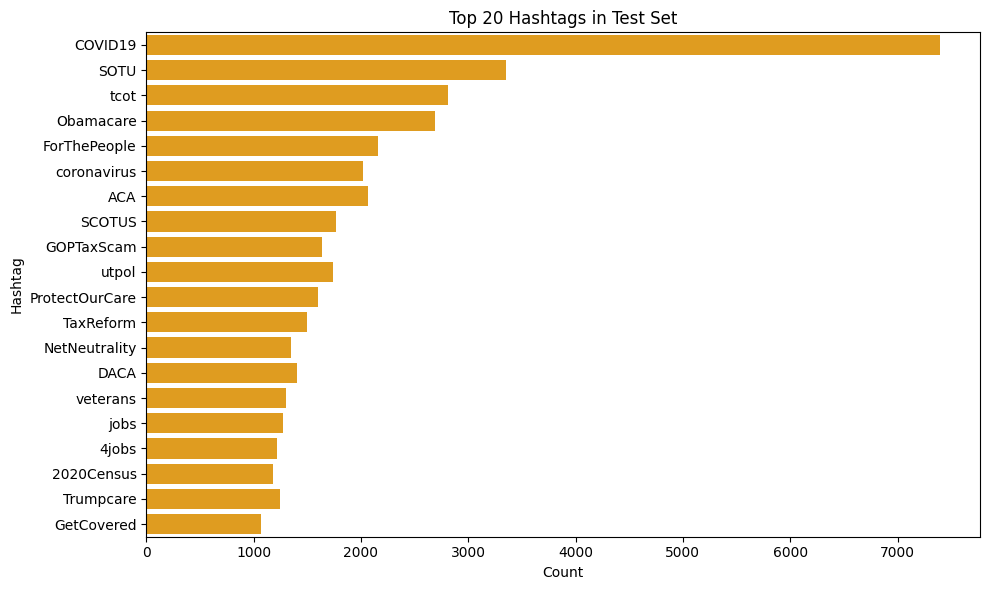

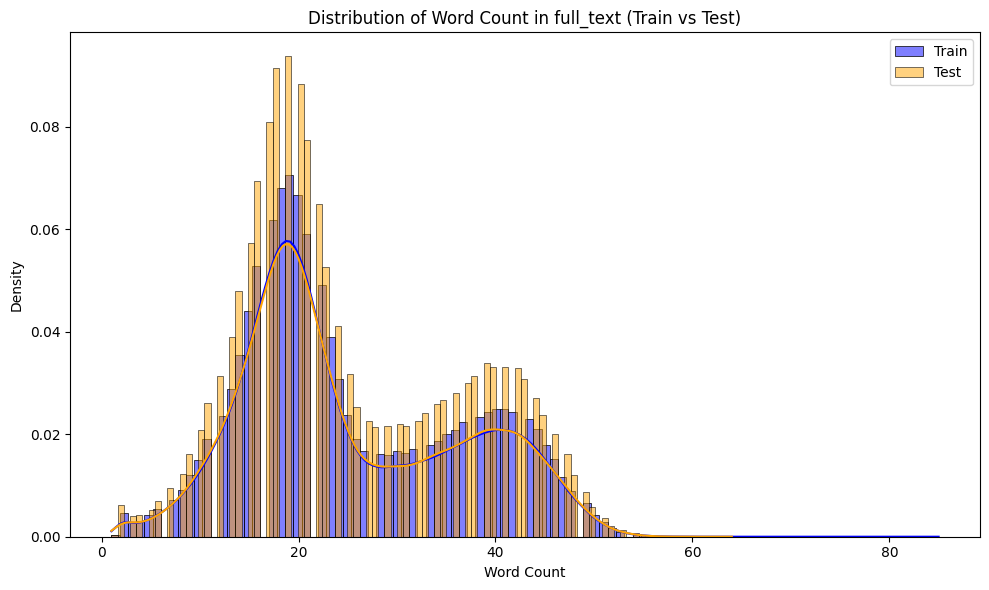

In [47]:
# Plot histograms for train and test favorite counts
plt.figure(figsize=(10, 6))
sns.histplot(train['favorite_count'], bins=1000, kde=True, color='blue', label='Train', stat='density', alpha=0.5)
sns.histplot(test['favorite_count'], bins=1000, kde=True, color='orange', label='Test', stat='density', alpha=0.5)
plt.xlim(0, 10000)
plt.title('Distribution of Favorite Counts (Train vs Test)')
plt.xlabel('Favorite Count')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Plot histograms for train and test retweet counts
plt.figure(figsize=(10, 6))
sns.histplot(train['retweet_count'], bins=1000, kde=True, color='blue', label='Train', stat='density', alpha=0.5)
sns.histplot(test['retweet_count'], bins=1000, kde=True, color='orange', label='Test', stat='density', alpha=0.5)
plt.xlim(0, 10000)
plt.title('Distribution of Retweet Counts (Train vs Test)')
plt.xlabel('Retweet Count')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Plot histograms for train and test year
plt.figure(figsize=(10, 6))
sns.histplot(x='year', data=train, color='blue', label='Train', alpha=0.5)
sns.histplot(x='year', data=test, color='orange', label='Test', alpha=0.5)
plt.title('Distribution of Year (Train vs Test)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Plot histograms for train and test party
plt.figure(figsize=(10, 6))
sns.countplot(x='party_id', data=train, color='blue', label='Train', alpha=0.5)
sns.countplot(x='party', data=test, color='orange', label='Test', alpha=0.5)
plt.title('Distribution of Party (Train)')
plt.xlabel('Party')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Show top 20 hashtags for train
top_20_train = top_train_hashtags.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_train.values, y=top_20_train.index, color='blue')
plt.title('Top 20 Hashtags in Train Set')
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.tight_layout()
plt.show()

# Show top 20 hashtags for test
top_20_test = top_test_counts.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_test.values, y=top_20_test.index, color='orange')
plt.title('Top 20 Hashtags in Test Set')
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.tight_layout()
plt.show()

# Plot Word Count Distribution
train_word_counts = train['full_text'].apply(lambda x: len(str(x).split()))
test_word_counts = test['full_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_word_counts, bins=100, color='blue', label='Train', stat='density', alpha=0.5, kde=True)
sns.histplot(test_word_counts, bins=100, color='orange', label='Test', stat='density', alpha=0.5, kde=True)
plt.title('Distribution of Word Count in full_text (Train vs Test)')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Data Cleaning
My plan for data cleaning and prep is as follows. First I'll process the full text by removing URLs, mentions, hashtags, special characters, extra spaces, and make everything lowercase.  Next, the year missing year values will be replaced with noyear. After that year, full_text, and the hashtags will be concatenated together.   This will create a single text string to be vectorized and fed into the models.  The training data will be split into a train and validation set using a 80-20 split.

In [ ]:
# Function to preprocess text data
def preprocess_text(text):
    # remove unicode special characters
    text = re.sub(r"\\x..", ' ', text)
    # remove b at start of string
    text = re.sub(r"^b", '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove special characters (keep only letters, numbers, and spaces)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    # stemming using NLTK's PorterStemmer
    stemmer = PorterStemmer()
    text = ' '.join(stemmer.stem(word) for word in text.split())
    # lemmatization using NLTK's WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    # Stop word removal using NLTK
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)        
    # Remove leading and trailing spaces
    text = text.strip()
    return text

def preprocess_dataset(df):
    # Apply preprocessing to the 'full_text' column
    df['full_text'] = df['full_text'].apply(preprocess_text)
    # apply preprocessing to the 'hashtags' column
    df['hashtags'] = df['hashtags'].apply(preprocess_text)
    # convert year to string with no decimal places
    df['year'] = df['year'].astype(str).str.replace('.0', '', regex=False)
    # Replace NaN values in year with 'noyear'
    df['year'] = df['year'].fillna('noyear')
    # Create a concatenation of columns for the output
    X = df['year'].astype(str) + ' ' + \
        df['full_text'].astype(str) + ' ' + \
        df['hashtags'].astype(str)
    # Remove leading and trailing spaces
    X = X.str.strip()
    return X

In [134]:
# Preprocess and split the dataset
train_preprocessed = preprocess_dataset(train)

# Map 'D' to 1 and 'R' to 0 in the target variable
train_y_preprocessed = train['party_id'].map({'D': 1, 'R': 0})

X_train, X_val, y_train, y_val = train_test_split(train_preprocessed, train_y_preprocessed, test_size=0.2, random_state=1337)


## Model

In [135]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [136]:
# Convert training and validation data to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [137]:
# use the keras text encoder limit to 1000 words
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [138]:
# Top 20 words in the vocabulary, nothing suprising, we can see 
# that the most common words are stop words like 'the', 'and', 'to', etc.
# If this wasn't a weekly assignment, I would probably use a more sophisticated 
# tokenizer and remove stop words.
vocab = np.array(encoder.get_vocabulary())
print("Vocabulary size:", len(vocab))
vocab[:20]


Vocabulary size: 1000


array(['', '[UNK]', 'amp', 'thi', '2019', '2018', '2017', '2020', 'today',
       '2016', '2015', 'work', 'american', 'thank', 'u', 'help', 'need',
       '2014', 'ha', 'famili'], dtype='<U24')

In [139]:
# Define the model architecture
# We will use a simple LSTM model followed by a dense layer for binary classification.
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [140]:
# Define the loss, optimizer, and metrics for the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [141]:
# Train the model
history = model.fit(train_dataset, epochs=10,
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/10


I0000 00:00:1753156377.844194   49343 cuda_dnn.cc:529] Loaded cuDNN version 90300


7411/7411 ━━━━━━━━━━━━━━━━━━━━ 132s 17ms/step - accuracy: 0.6625 - loss: 0.5591 - val_accuracy: 0.6745 - val_loss: 0.5206
Epoch 2/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 129s 17ms/step - accuracy: 0.7079 - loss: 0.5099 - val_accuracy: 0.6948 - val_loss: 0.5063
Epoch 3/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 128s 17ms/step - accuracy: 0.7119 - loss: 0.5033 - val_accuracy: 0.7010 - val_loss: 0.5017
Epoch 4/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 128s 17ms/step - accuracy: 0.7158 - loss: 0.4975 - val_accuracy: 0.6995 - val_loss: 0.4976
Epoch 5/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 130s 18ms/step - accuracy: 0.7200 - loss: 0.4925 - val_accuracy: 0.6995 - val_loss: 0.4927
Epoch 6/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 349s 47ms/step - accuracy: 0.7235 - loss: 0.4878 - val_accuracy: 0.7042 - val_loss: 0.4876
Epoch 7/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 135s 18ms/step - accuracy: 0.7271 - loss: 0.4838 - val_accuracy: 0.7151 - val_loss: 0.4855
Epoch 8/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 136s 18ms/step - accuracy: 0.7310 - lo

In [142]:
val_loss, val_acc = model.evaluate(val_dataset)

print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)

1853/1853 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7246 - loss: 0.4803
Validation Loss: 0.4833497405052185
Validation Accuracy: 0.7231382727622986


(0.0, 0.5326994121074676)

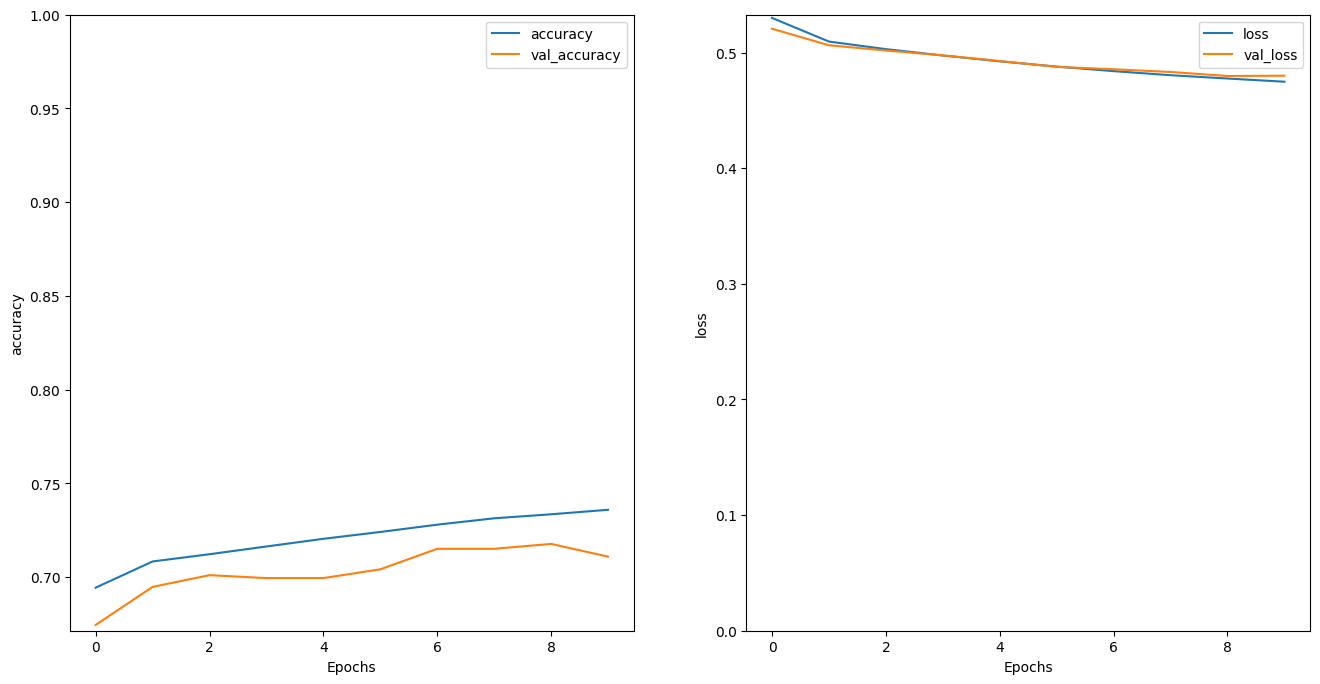

In [143]:
# Plot the training and validation accuracy and loss
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## Results and Analysis

## Discussion and Conclusion

# References
[1] Cantay Caliskan. Congressional Tweet Competition - Spring 2022. https://kaggle.com/competitions/congressionaltweetcompetitionspring2022, 2022. Kaggle.